<h1> Stock Market Graph Analysis </h1>

In [2]:
library('igraph')
library('dplyr')
library('anytime')

In [3]:
num_days = 765
list_files <- list.files(path = "finance_data/data/", pattern = "*.csv")

<h2> Helper Functions </h2>

In [4]:
get_return = function(a, unnormalize = FALSE){
    
    pi_t = a
    
    pi_t_1 = c(pi_t[1], pi_t)
    pi_t_1 = pi_t_1[1:(length(pi_t_1)-1)]
    
    qi_t = (pi_t - pi_t_1) / pi_t_1
    
    r_t = log(1 + qi_t)
    
    if(unnormalize)
        return(qi_t)
    else
        return(r_t)
}

In [5]:
get_correlation = function(i, j){
    
    num = mean(i*j) - mean(i) * mean(j)
    den = (mean(i^2) - mean(i)^2) * (mean(j^2) - mean(j)^2)
    return(num / sqrt(den))
    
}

In [6]:
get_edge_list = function(stock_returns, file_name){
    
    
    file.create(file_name)
    stocks <- names(stock_returns)
    edge_list <- data.frame(matrix(ncol = 3, nrow = 0))
    x <- c("stock_i", "stock_j", "weight")
    colnames(edge_list) <- x

    for(i in 1:(length(stocks)-1)){
        for(j in (i+1):length(stocks)){
            corr = get_correlation(stock_returns[[i]], stock_returns[[j]])
            weight = sqrt(2*(1 - corr))
            #edge_list <- rbind(edge_list, data.frame("stock_i" = stocks[i],  "stock_j" = stocks[j], "weight" = weight))
            cat(paste(stocks[i],stocks[j],weight,"\n",sep = "\t"), file = file_name, append = TRUE)
            
        }
    }
}

In [7]:
get_stock_returns = function(unnormalize_flag = FALSE){
    
    stock_returns <- list()

    for(file_name in list_files){

        stock <- read.csv(paste("finance_data/data/", file_name, sep = ""))
        close <- unlist(stock['Close'])

        if(length(close) == num_days)
            stock_returns[[gsub(pattern = "\\.csv$", "", file_name)]] <- get_return(close, unnormalize =  unnormalize_flag)
    }

        return(stock_returns)

}

In [83]:
get_edge_list(get_stock_returns(), "stock_edge_list.txt")

In [4]:
edge_list <- as.matrix(read.table('stock_edge_list.txt', sep = "\t", 
                                         header = FALSE, quote = "", check.names = FALSE))
colnames(edge_list) = c("stock_i", "stock_j", "weight", "\t")
stock_network = graph.data.frame(edge_list, directed=FALSE)

<h2> Graph Properties </h2>

In [5]:
cat("Is graph weighted? ", is_weighted(stock_network))
cat("\nNumber of edges in the correlation graph = ", length(E(stock_network)))
cat("\nNumber of vertices in the correlation graph = ", length(V(stock_network)))

Is graph weighted?  TRUE
Number of edges in the correlation graph =  121771
Number of vertices in the correlation graph =  494

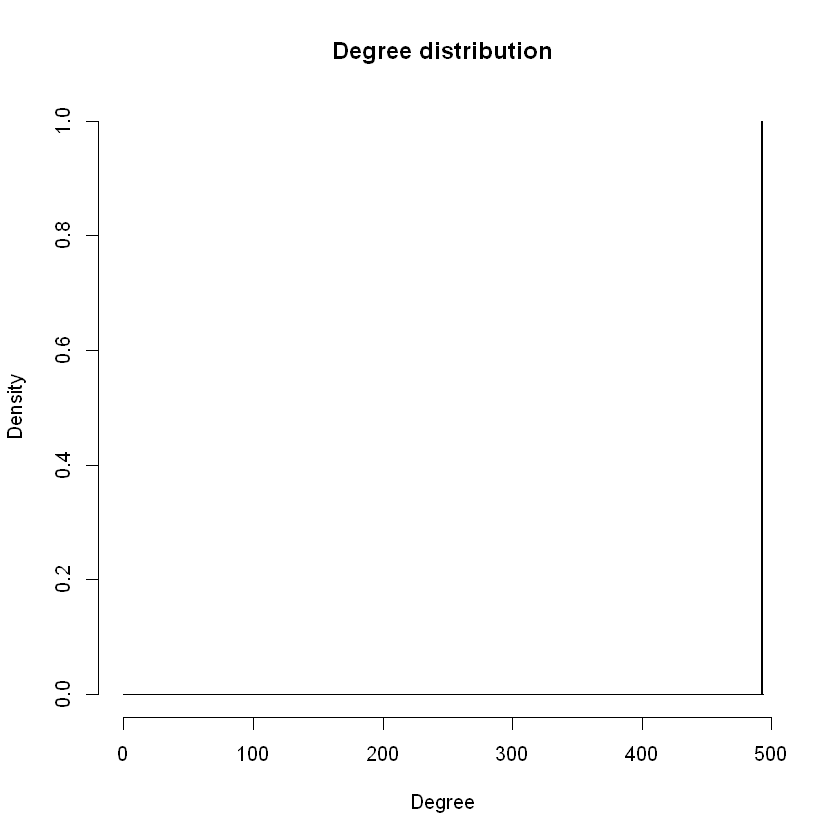

In [6]:
degree <- degree(stock_network, v = V(stock_network))
hist(degree, breaks = seq(from = 0, to = max(degree) + 1, by = 1), freq = F,
 main = 'Degree distribution', xlab = "Degree")

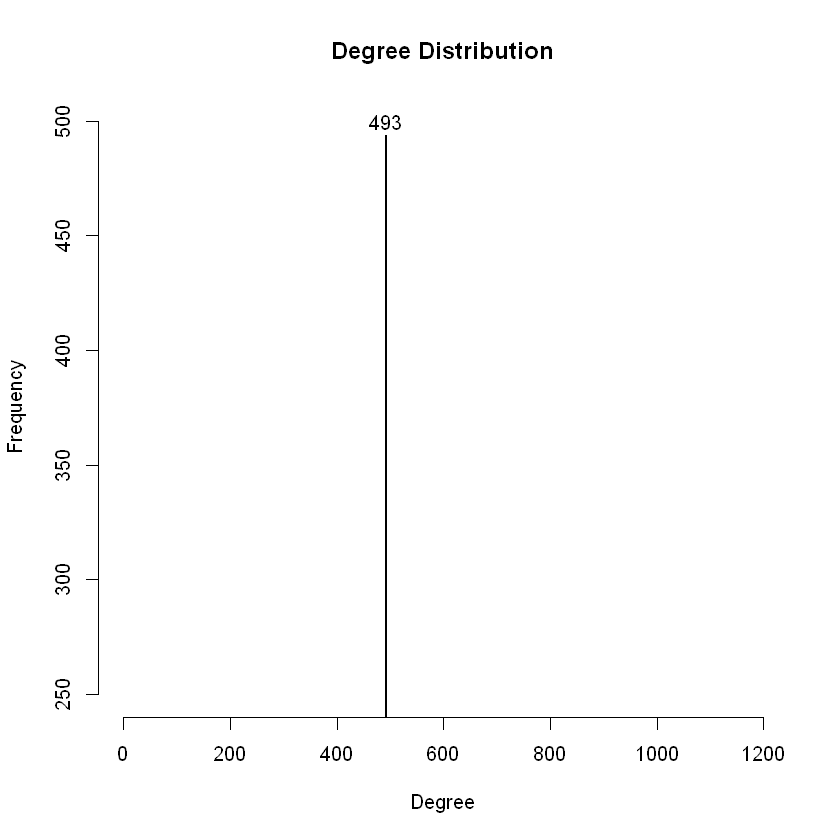

In [13]:
degree_distribution <- degree(stock_network)
histogram <- hist(degree_distribution, breaks=seq(from=490, to=500, by=1),
                  xlim=c(0,1200), ylim=c(250,500), 
                  xlab="Degree",ylab="Frequency", main="Degree Distribution")
text(histogram$mids,histogram$counts-1,labels=histogram$counts-1, adj=c(0.5, -0.5))

<h2> Correlation graph </h2>

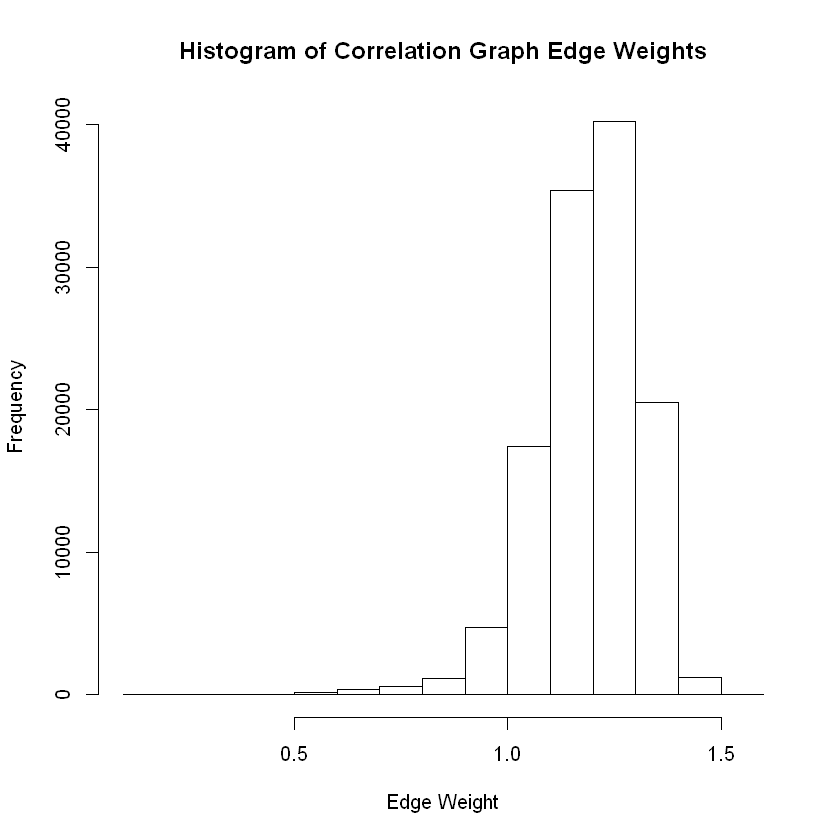

In [92]:
hist(as.numeric(edge_list[, 3]), xlab = "Edge Weight", main = "Histogram of Correlation Graph Edge Weights")

In [ ]:
get_edge_list(get_stock_returns(unnormalize_flag = TRUE), "stock_edge_list_unnormalized.txt")

edge_list_unnormalized <- as.matrix(read.table("stock_edge_list_unnormalized.txt", sep = "\t", 
                                         header = FALSE, quote = "", check.names = FALSE))
colnames(edge_list_unnormalized) = c("stock_i", "stock_j", "weight", "\t")
stock_network_unnormalized = graph.data.frame(edge_list_unnormalized, directed=FALSE)

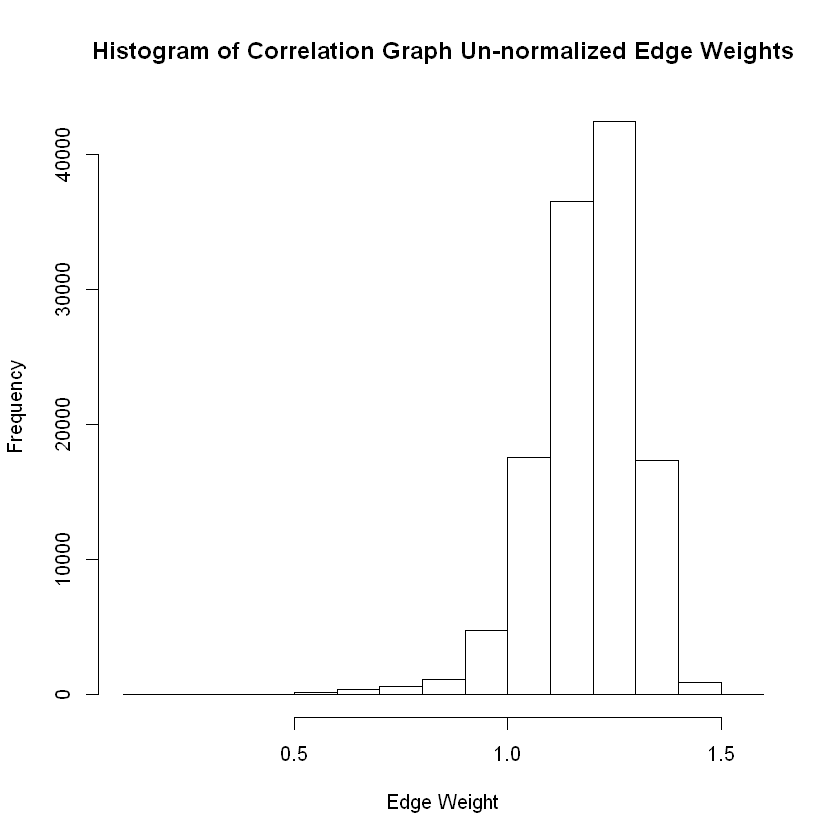

In [513]:
hist(as.numeric(edge_list_unnormalized[, 3]),
     xlab = "Edge Weight", main = "Histogram of Correlation Graph Un-normalized Edge Weights")

<h2> Minimum Spanning Tree of Correlation Graph </h2>

In [75]:
stock_mst = mst(stock_network)
cat("Number of edges in the MST of correlation graph = ", length(E(stock_mst)))

Number of edges in the MST of correlation graph =  493

In [76]:
for(i in 1:length(V(stock_mst)))
    stock_mst <- set_vertex_attr(stock_mst, "sector", index = V(stock_mst)[i], 
                                 as.character(name_sector[V(stock_mst)[i]$name]))

In [164]:
plot_vine_cluster = function(stock_mst){
    
    
    name_sectors <- read.table('finance_data/Name_sector.csv', sep=',', header=TRUE)
    sectors <- group_by(name_sectors, Sector)
    colors = palette(rainbow(nrow(unique(summarize(sectors)))))
    color_palette = cbind(summarize(sectors), colors)
    name_sectors_colors <- left_join(name_sectors, color_palette, by='Sector')
    vertex_colors = rep("#000000", length(V(stock_mst)))
    for (v in V(stock_mst)$name) {
       vertex_colors[which(V(stock_mst)$name == v)] = as.character(name_sectors_colors[which(name_sectors_colors$Symbol == v), 
                                                                                       3]) 
    }

    plot(stock_mst, vertex.size=3, vertex.label=NA, vertex.color=vertex_colors)
    legend(x = -1.5, y = 1.4, legend=unlist(color_palette[1]), fill=unlist(color_palette[2]), ncol=1, cex=0.6)
}

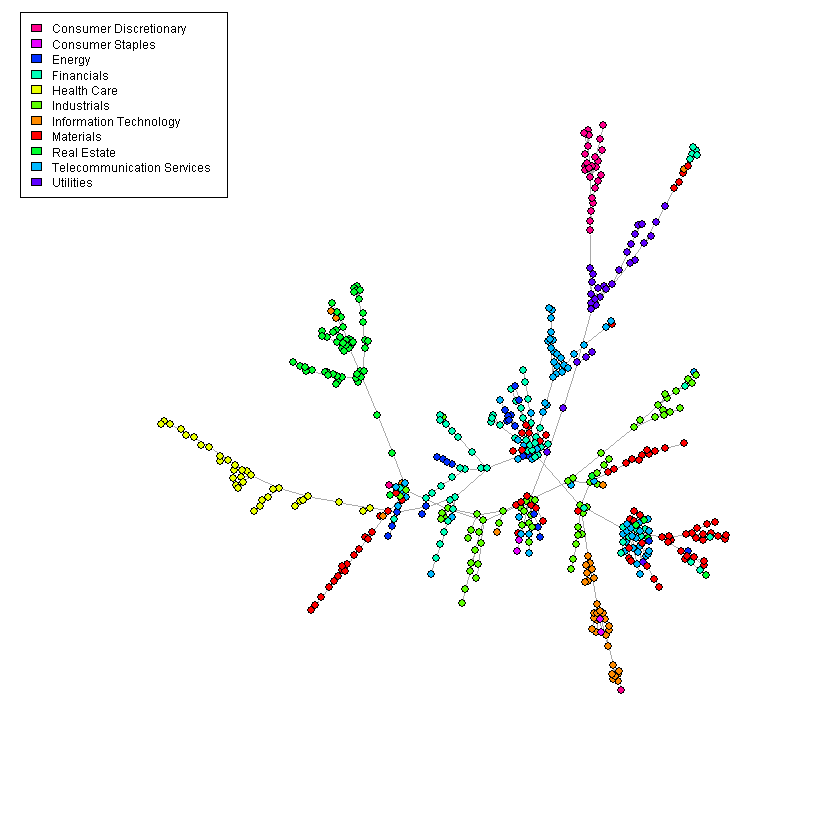

In [165]:
plot_vine_cluster(stock_mst)

<h2> Sector Clustering in MSTs </h2>

In [61]:
calculate_alpha = function(stock_mst){

    S = table(name_sector)
    Vcount = length(V(stock_mst))
    alpha1 = 0
    alpha2 = 0


    for(vid in 1:Vcount){

        sec = V(stock_mst)[vid]$sector
        neighb = as.vector(neighbors(stock_mst, vid))

        q = 0

        for(i in neighb)
            if(V(stock_mst)[i]$sector == sec)
                q = q + 1

        alpha1 = alpha1 +  q/length(neighb)
        alpha2 = alpha2 +  S[sec] / Vcount

    }

    cat("Alpha1 = ", alpha1 / Vcount)
    cat("\nAlpha2 = ", alpha2 / Vcount)

}

In [62]:
calculate_alpha(stock_mst)

Alpha1 =  0.8289301
Alpha2 =  0.1168967

<h4> Alpha2 = 0.1141 if we remove the 11 symbols with shorter length from name_sector also </h4>

<h2> Correlation Graphs for Weekly Data </h2>

In [20]:
stock_returns <- list()

for(file_name in list_files){
    
    stock <- read.csv(paste("finance_data/data/", file_name, sep = ""))
    close <- unlist(stock['Close'])
    dates <- unlist(stock['Date'])

    if(length(close) == num_days)
        #Monday is day 1 in wday
        stock_returns[[gsub(pattern = "\\.csv$", "", file_name)]] <- get_return(close[which(as.POSIXlt(dates)$wday == 1)])
}

get_edge_list(stock_returns, file_name = "stock_edge_list_weekly.txt")

In [63]:
edge_list_weekly <- as.matrix(read.table("stock_edge_list_weekly.txt", sep = "\t", 
                                         header = FALSE, quote = "", check.names = FALSE))
colnames(edge_list_weekly) = c("stock_i", "stock_j", "weight", "\t")
stock_network_weekly = graph.data.frame(edge_list_weekly, directed=FALSE)

In [64]:
stock_mst_weekly = mst(stock_network_weekly)
cat("Number of edges in the MST of correlation graph = ", length(E(stock_mst_weekly)))

Number of edges in the MST of correlation graph =  493

In [73]:
for(i in 1:length(V(stock_mst_weekly)))
    stock_mst_weekly <- set_vertex_attr(stock_mst_weekly, "sector", index = V(stock_mst_weekly)[i], 
                                 as.character(name_sector[V(stock_mst_weekly)[i]$name]))


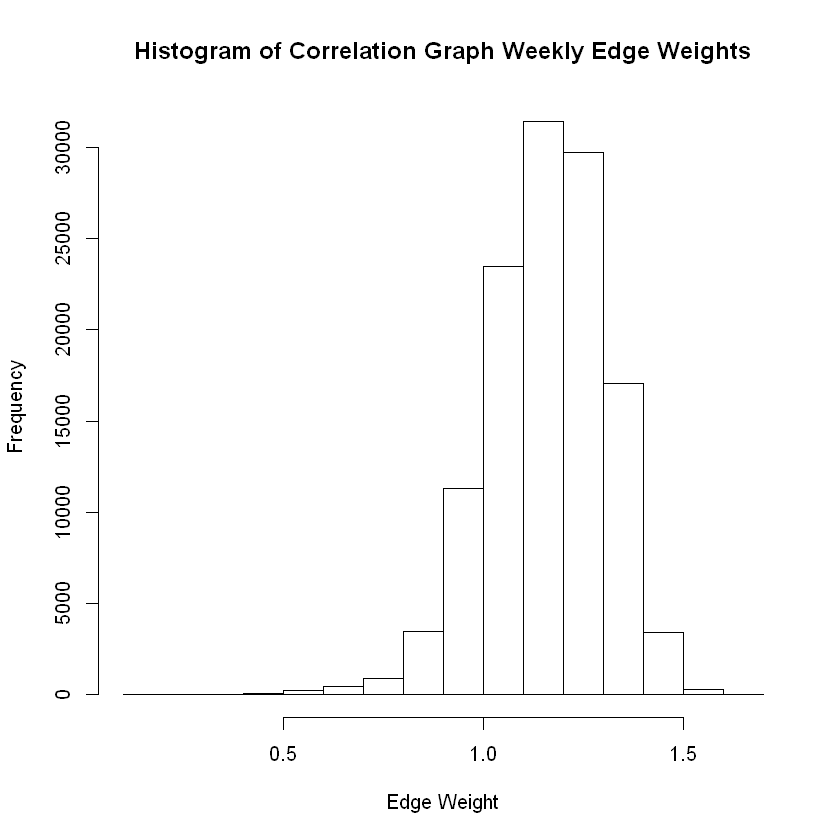

In [66]:
hist(as.numeric(edge_list_weekly[, 3]),
     xlab = "Edge Weight", main = "Histogram of Correlation Graph Weekly Edge Weights")

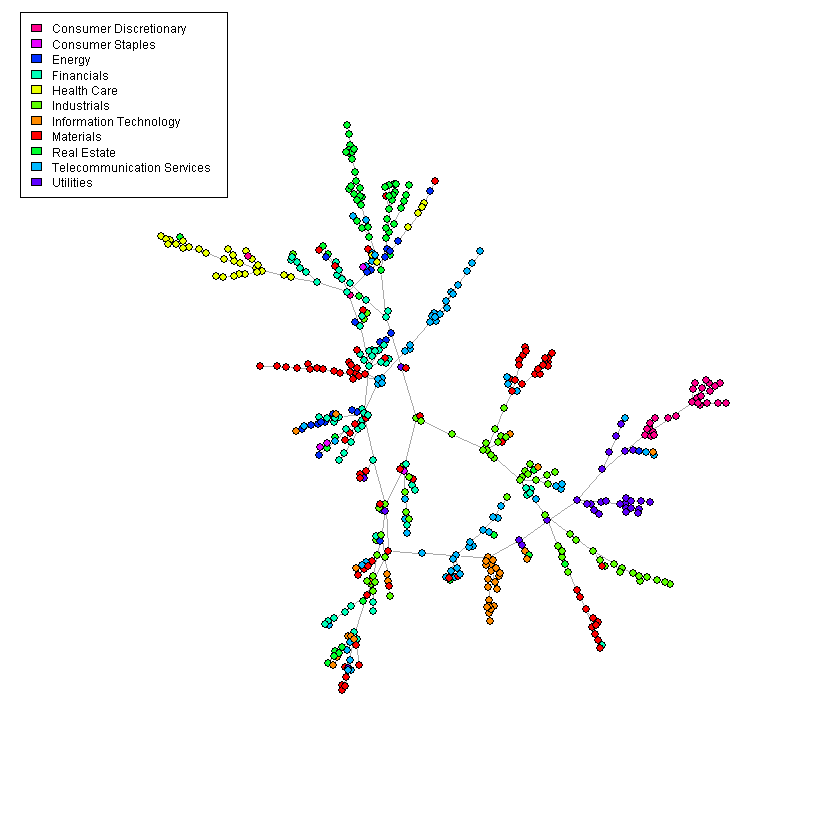

In [167]:
plot_vine_cluster(stock_mst_weekly)

In [74]:
calculate_alpha(stock_mst_weekly)

Alpha1 =  0.7453313
Alpha2 =  0.1168967